In [2]:
import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict

if "../" not in sys.path:
    sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

# 创建环境
env = BlackjackEnv()


In [ ]:

def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    创建基于给定Q函数和epsilon的epsilon-greedy策略。
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

def mc(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    使用Epsilon-Greedy策略进行蒙特卡洛控制（每次访问版本）。
    """
    
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(1, num_episodes + 1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # 生成一个回合
        episode = []
        state = env.reset()
        for t in range(100):
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        for state, action, reward in episode:
            sa_pair = (tuple(state), action)
            G = sum([x[2] * (discount_factor ** i) for i, x in enumerate(episode)])
            # 计算平均回报
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[tuple(state)][action] = returns_sum[sa_pair] / returns_count[sa_pair]

        # 策略隐式更新
        policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    return Q, policy


Episode 500000/500000.

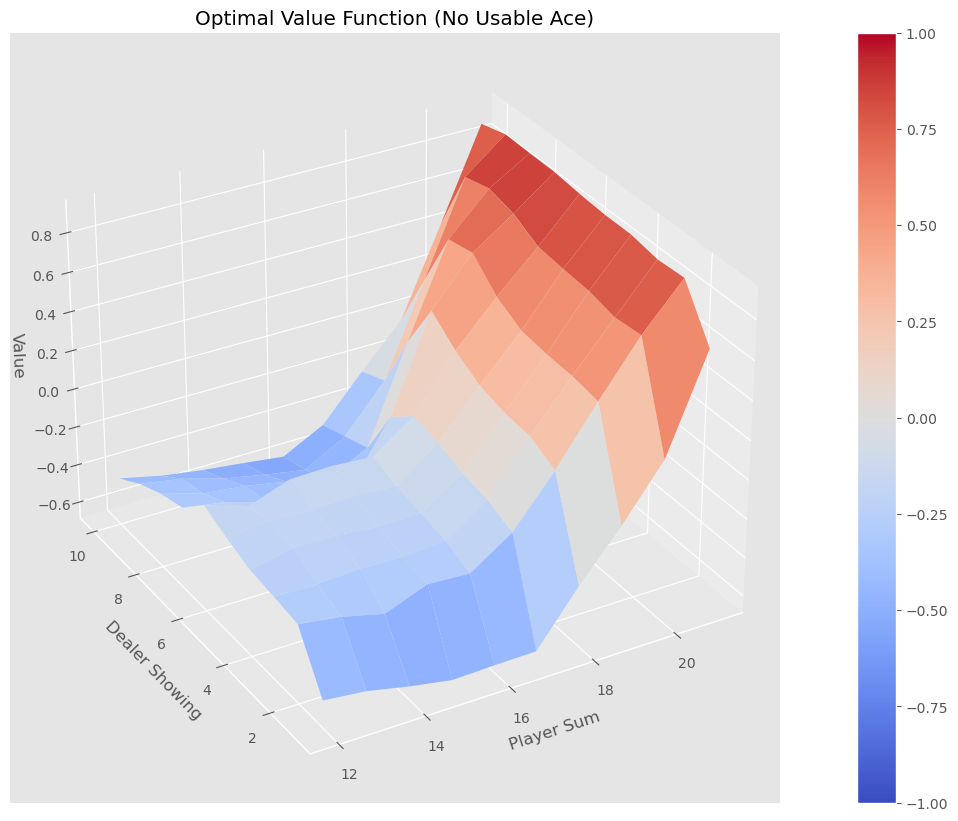

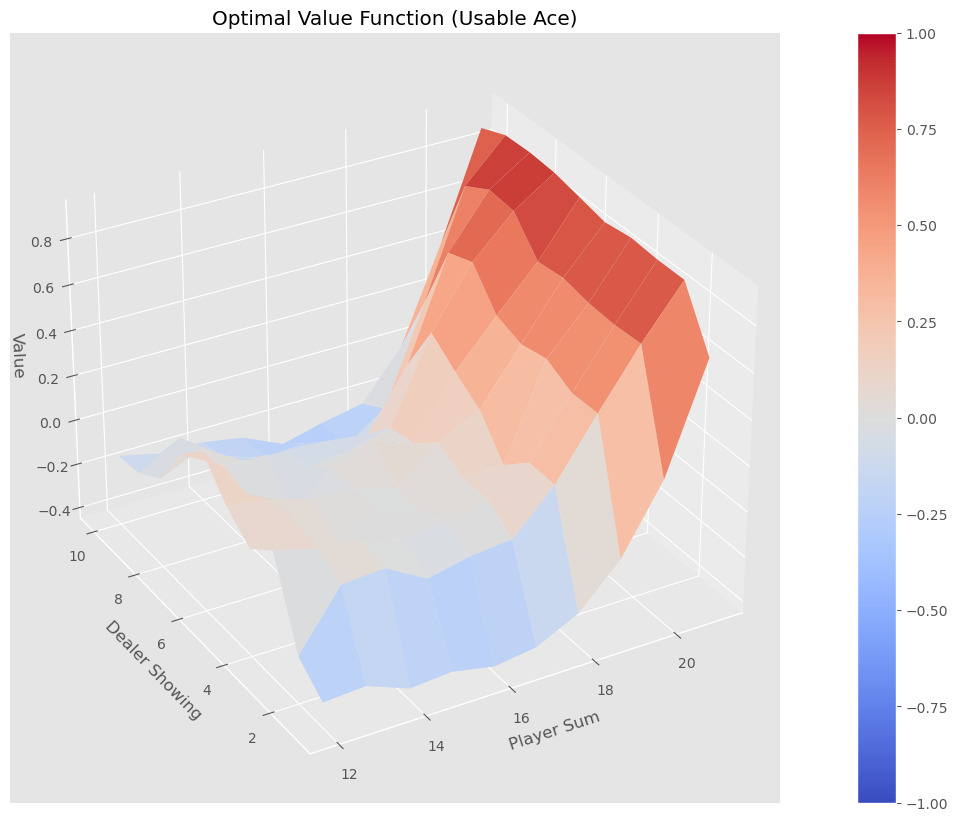

In [5]:
Q, policy = mc(env, num_episodes=500000, epsilon=0.1)

# 创建值函数
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value

plotting.plot_value_function(V, title="Optimal Value Function")